In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

image shape: (410, 615, 3)


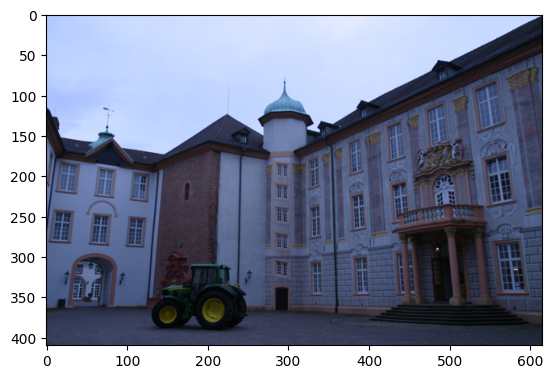

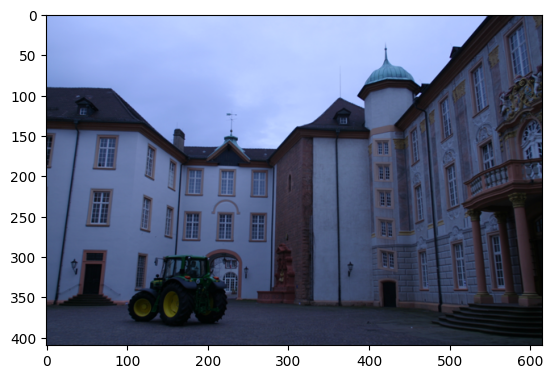

In [3]:
# load the images
im_left = cv2.imread('../data/0014_2.png')
print("image shape:", im_left.shape)
plt.imshow(im_left[:, :, ::-1])
plt.figure()
im_right = cv2.imread('../data/0017_2.png')
plt.imshow(im_right[:, :, ::-1])
images = [im_left, im_right]

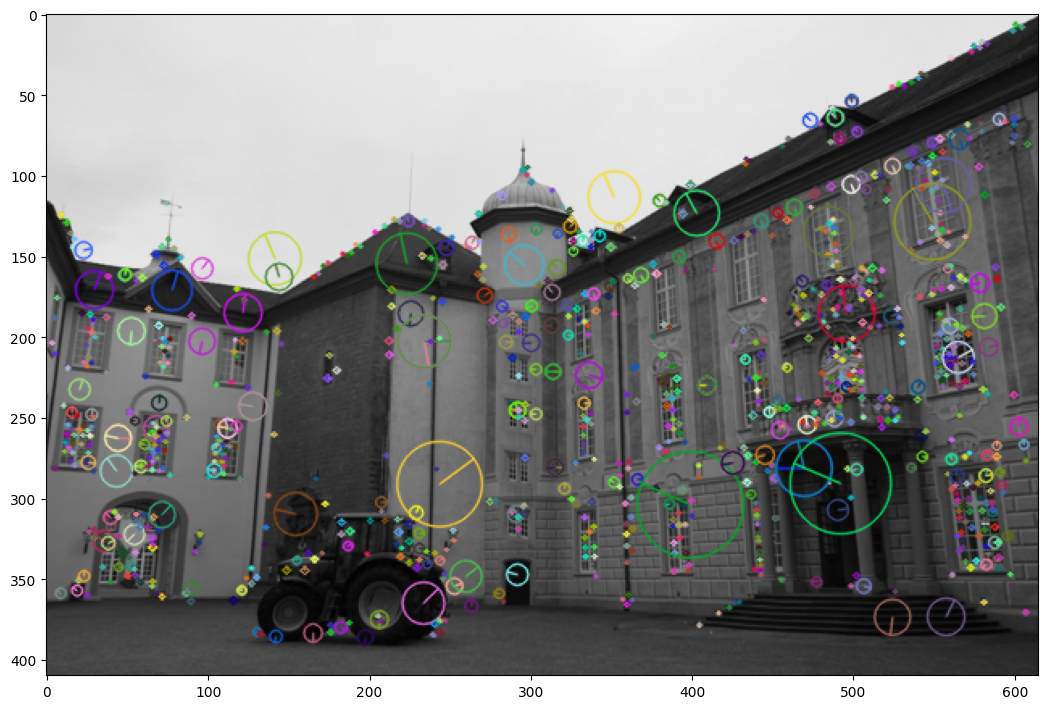

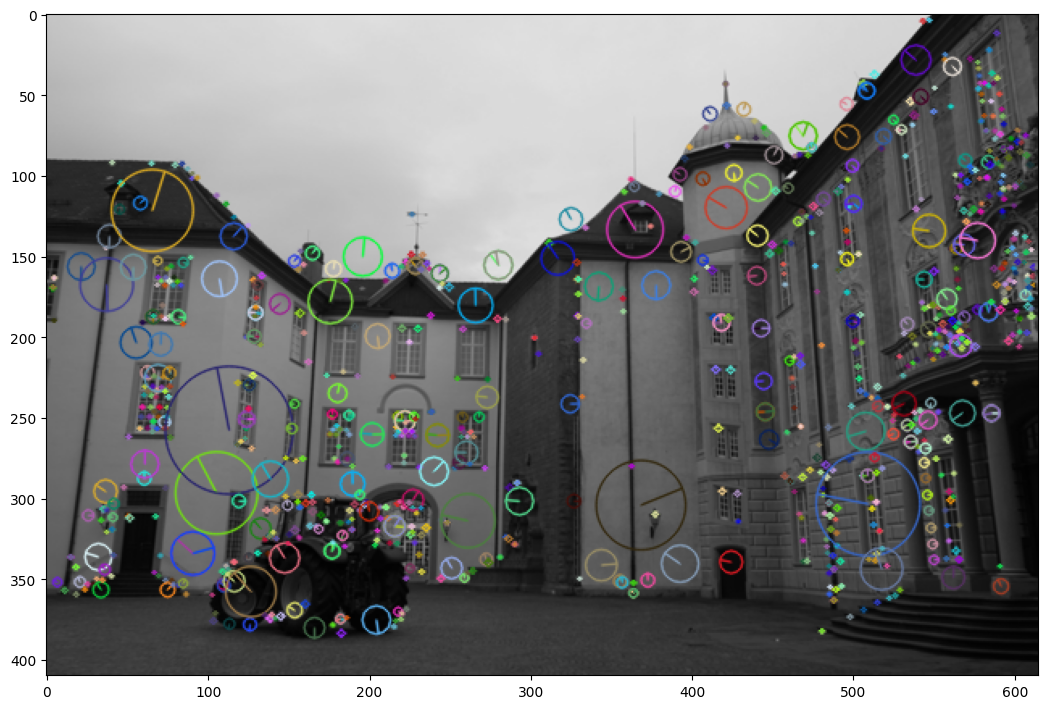

In [4]:
""" Detects SIFT features in all of the images
"""
keypoints = []
descriptions = []
for im in images:
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  plt.imshow(out_im)

num matches 598


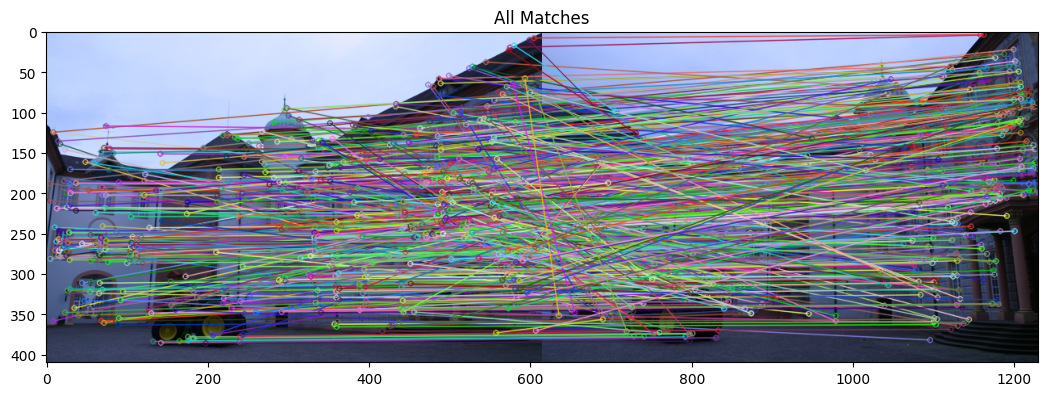

In [5]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])

print("num matches", len(matches))


matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)


In [6]:
""" Compute calibrated coordinates
"""

# For the satsok castle images
f1 = f2 = 552
u0 = 307.5
v0 = 205

K = np.array([[f1, 0, u0],
              [0, f2, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T
uncalibrated_2 = np.array(uncalibrated_2).T

k_inv = np.linalg.inv(K)

calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T


In [7]:
from lse import least_squares_estimation

E_least = least_squares_estimation(calibrated_1, calibrated_2)
print("E least", E_least)

E least [[ 0.16576508 -0.26425128  0.49683621]
 [-0.24883257 -0.94012561 -0.04428804]
 [ 0.35380308  0.00178721  0.76351288]]


[[ 0.00905853  0.16687283 -0.05660131]
 [-0.58114853 -0.02806003  0.81133061]
 [ 0.1440723  -0.9736465   0.05783624]]
[466 404 156 304 341 390 482 266 132 220  89 385   2  18 171  72 319  52
 335 382 135 399   8 242 260  90 472 422 332  43 233  56  20 143 217 308
 250 117 311 167 116 441 147 110 105  58 453 329 409 226  86 231 223  73
  34 359 130 150 259 303 157  40 229   9 417 322  75 313  65 380 406 155
 191 202 316 154 119 372 261 137 124  42 205  23 557 474 125  15  55 134
 140 473 139 249  91  82 252 240 248  81 278  38 371 262 185 106 306  21
 396  85 415 454 292 323 291 133 416 410 225 317 413 101 173 238 305 214
  92 123 328 251 108 221 348 338 296 376 160 241 427  13 327 131 369 307
  31  71  70 318 445 440 174 237 469  87  84 274 109 483 302 312  77 434
  32 222 400 203 187 129  88 186 354 310 455 424 309]
E_ransac [[ 0.00905853  0.16687283 -0.05660131]
 [-0.58114853 -0.02806003  0.81133061]
 [ 0.1440723  -0.9736465   0.05783624]]
Num inliers (175,)


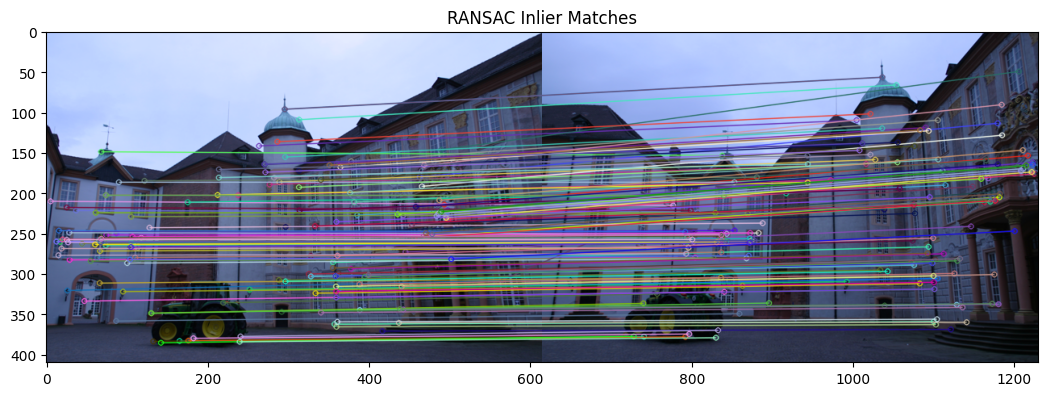

In [8]:
from ransac import ransac_estimator

# running this cell will take a while!!!

E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
print("E_ransac", E_ransac)
print("Num inliers", inliers.shape)

inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

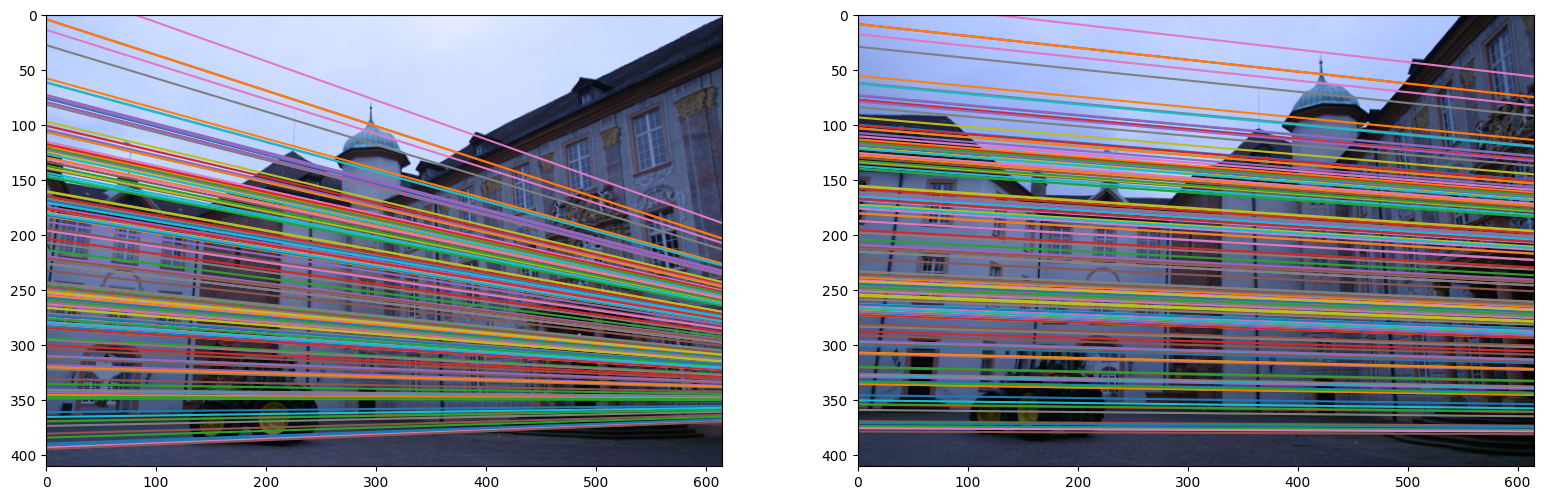

In [9]:
from plot_epi import plot_epipolar_lines

uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [10]:
from pose import pose_candidates_from_E

transform_candidates = pose_candidates_from_E(E_ransac)
print("transform_candidates", transform_candidates)
for c in transform_candidates:
  print(np.linalg.det(c['R']))

np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]).T

transform_candidates [{'T': array([-0.98431077, -0.0567597 , -0.16706478]), 'R': array([[-0.89359327, -0.09992568, -0.43761389],
       [ 0.09484019, -0.9949279 ,  0.03352336],
       [ 0.43874412,  0.01154713, -0.89853785]])}, {'T': array([-0.98431077, -0.0567597 , -0.16706478]), 'R': array([[-0.68305937, -0.20107775, -0.7021379 ],
       [-0.18575693,  0.97757071, -0.09924647],
       [-0.70634571, -0.06263575,  0.70509042]])}, {'T': array([0.98431077, 0.0567597 , 0.16706478]), 'R': array([[-0.89359327, -0.09992568, -0.43761389],
       [ 0.09484019, -0.9949279 ,  0.03352336],
       [ 0.43874412,  0.01154713, -0.89853785]])}, {'T': array([0.98431077, 0.0567597 , 0.16706478]), 'R': array([[-0.68305937, -0.20107775, -0.7021379 ],
       [-0.18575693,  0.97757071, -0.09924647],
       [-0.70634571, -0.06263575,  0.70509042]])}]
-1.0000000000000002
-1.0000000000000002
-1.0000000000000002
-1.0000000000000002


array([[ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  0,  1]])

In [11]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

(598, 3)
in
[[-1.6252974   0.          0.         ...  0.          0.
   0.        ]
 [ 1.28884883  0.          0.         ...  0.          0.
   0.        ]]
in
[[-1.6252974   2.2859459   0.         ...  0.          0.
   0.        ]
 [ 1.28884883 -2.15132683  0.         ...  0.          0.
   0.        ]]
in
[[-1.6252974   2.2859459   4.54043196 ...  0.          0.
   0.        ]
 [ 1.28884883 -2.15132683 -4.13469251 ...  0.          0.
   0.        ]]
in
[[-1.6252974   2.2859459   4.54043196 ...  0.          0.
   0.        ]
 [ 1.28884883 -2.15132683 -4.13469251 ...  0.          0.
   0.        ]]
in
[[-1.6252974   2.2859459   4.54043196 ...  0.          0.
   0.        ]
 [ 1.28884883 -2.15132683 -4.13469251 ...  0.          0.
   0.        ]]
in
[[-1.6252974   2.2859459   4.54043196 ...  0.          0.
   0.        ]
 [ 1.28884883 -2.15132683 -4.13469251 ...  0.          0.
   0.        ]]
in
[[-1.6252974   2.2859459   4.54043196 ...  0.          0.
   0.        ]
 [ 1.28884883 -

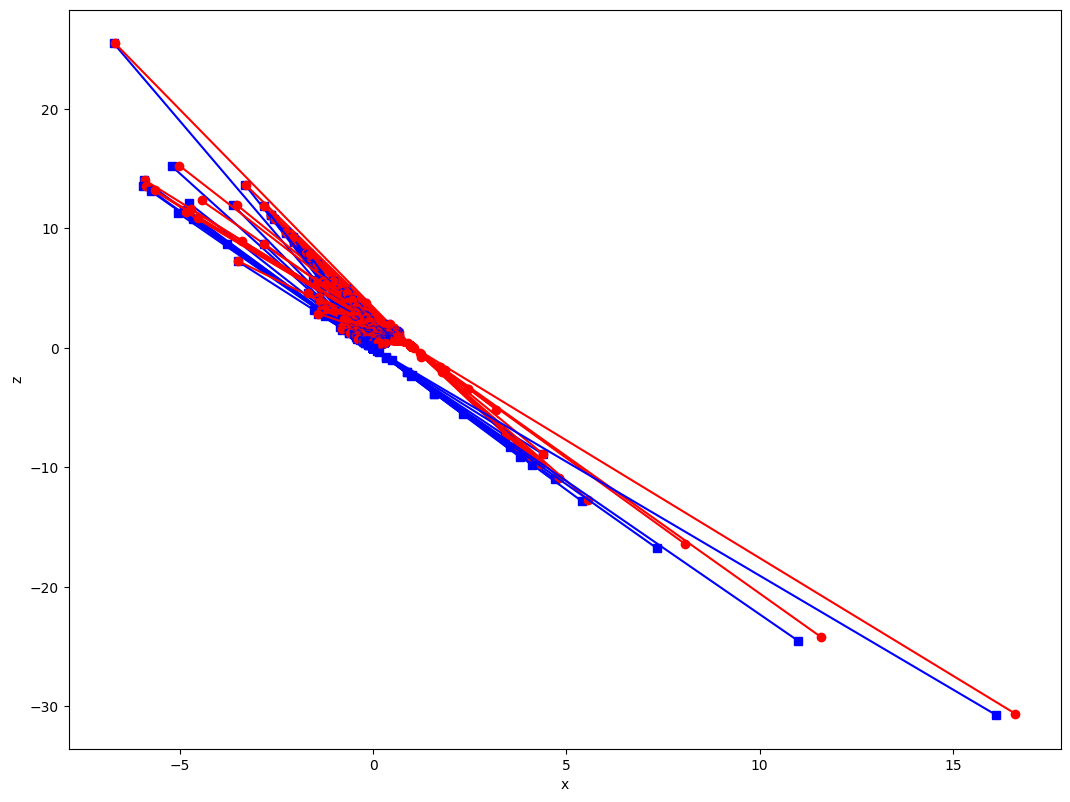

In [12]:
from recon3d import reconstruct3D 

P1, P2, T, R = reconstruct3D(transform_candidates, calibrated_1, calibrated_2)

plot_reconstruction(P1, P2, T, R)

(3, 598)
(598, 3)
[[-3.23044454e-01  2.02867877e-01  7.08889423e-01]
 [ 3.96957847e+00 -5.89845403e-01 -7.39674567e+00]
 [-1.24394059e+01 -7.50901708e-01  2.28657173e+01]
 ...
 [ 6.40175761e-01 -1.25481450e-01  3.26807574e-01]
 [ 5.97285153e-01  1.55329605e-03  3.30803944e-01]
 [ 8.53148548e-01  1.24320544e-01  4.09607006e-01]]


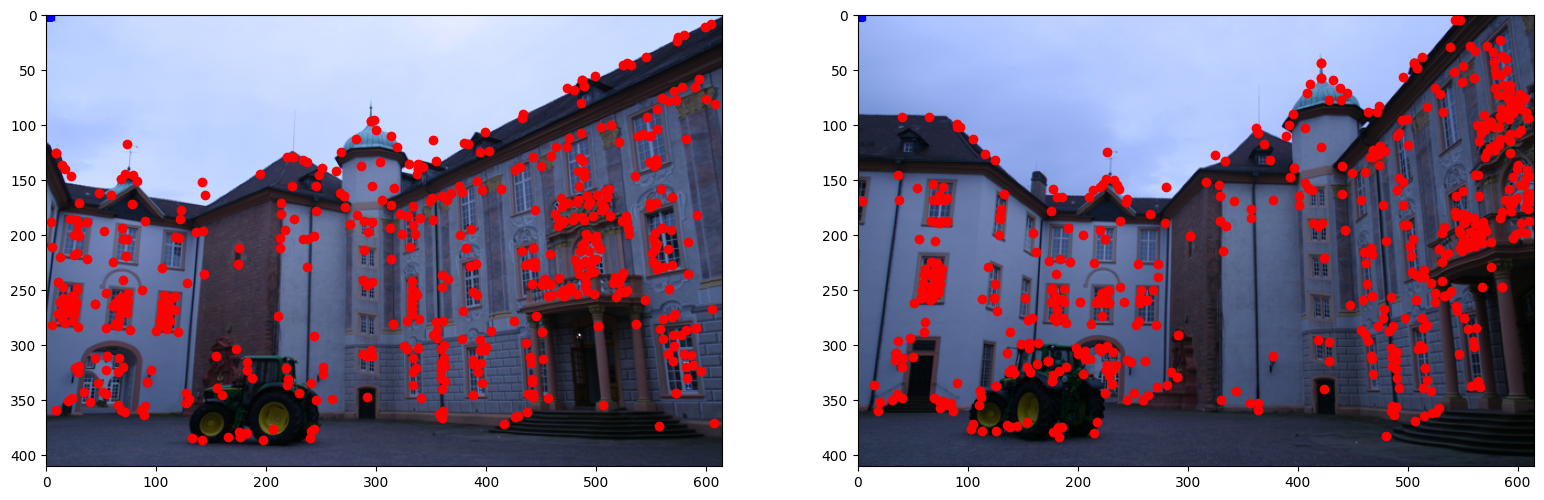

In [13]:
from show_reproj import show_reprojections

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)